In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In [4]:
baseline_file = get_baseline()
runName = os.path.split(baseline_file)[-1].replace('.db', '')

opsdb = maf.OpsimDatabase(baseline_file)
print(runName)

baseline_v2.1_10yrs


The AGN TimeLag metric looks at the timing of visits and calculates the (mean, min or max) of the interval between visits. This difference is then compared to the time interval required for nyquist sampling over the 'time lag' period. The value of `time lag / (1 + z + time interval` is returned, if it is above the nyquist threshold of 2.2.

There are modest magnitude limit cuts in g and r bands before a visit is counted, but no other bandpasses. Most short visits will be counted.

In [5]:
threshold = 2.2
m = maf.AGN_TimeLagMetric(threshold=threshold, z=1, lag=100)
s = maf.HealpixSlicer(nside=64, useCache=False)
sql = ''
summaryMetrics = maf.extendedSummary()
summaryMetrics += [maf.AreaThresholdMetric(lower_threshold = threshold)]
plotDict = {'percentileClip': 98, 'figsize': (8, 5)}

bundle = maf.MetricBundle(m, s, sql, runName=runName, summaryMetrics=summaryMetrics, plotDict=plotDict)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [6]:
g = maf.MetricBundleGroup({'TimeLag': bundle}, opsdb, 'temp', None)
g.runAll()

Querying table None with no constraint for columns ['observationStartMJD', 'filter', 'fieldRA', 'rotSkyPos', 'fiveSigmaDepth', 'fieldDec'].
Found 2081749 visits
Running:  ['TimeLag']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/maps/dustMap.py:42: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 83716 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

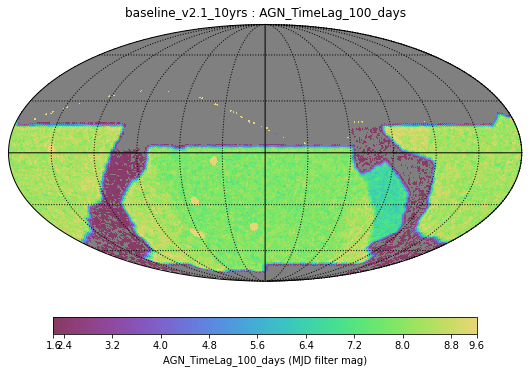

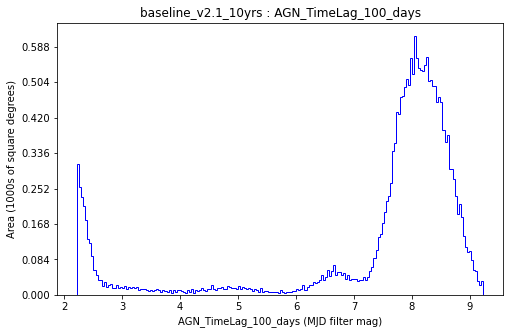

In [7]:
bundle.plot()

In [8]:
bundle.summaryValues

{'Mean': 11.250044054741247,
 'Rms': 98.15993962694031,
 'Median': 8.027398740494112,
 'Max': 4658.174586777808,
 'Min': 2.200056584425633,
 'N(+3Sigma)': 39,
 'N(-3Sigma)': 0,
 'Count': 26618,
 '25th%ile': 7.561646817902147,
 '75th%ile': 8.391933596034143,
 'AreaThreshold': 22340.318248230837}

In [9]:
# Variance across (most of) current set of simulations?
summaries = maf.get_metric_summaries()
families = maf.get_family_descriptions()

In [10]:
metrics = []
for f in 'ugrizy':
    metrics += [m for m in summaries if 'TimeLag' in m and 'Median' in m and f"{f} band" in m]
for f in 'ugrizy':
    metrics += [m for m in summaries if 'TimeLag' in m and 'Area' in m and f"{f} band" in m]
short_names = [m.replace(' HealpixSlicer', '') for m in metrics]
styles = ['c-', 'g-', 'y-', 'r-', 'm-', 'k-'] + ['c:', 'g:', 'y:', 'r:', 'm:', 'k:']
mset = maf.create_metric_set_df('AGN timelag', metrics, short_names, styles)

In [11]:
fams = [f for f in families.index if not f.startswith('ddf')]
runs = families.explode(['run']).loc[fams]['run']

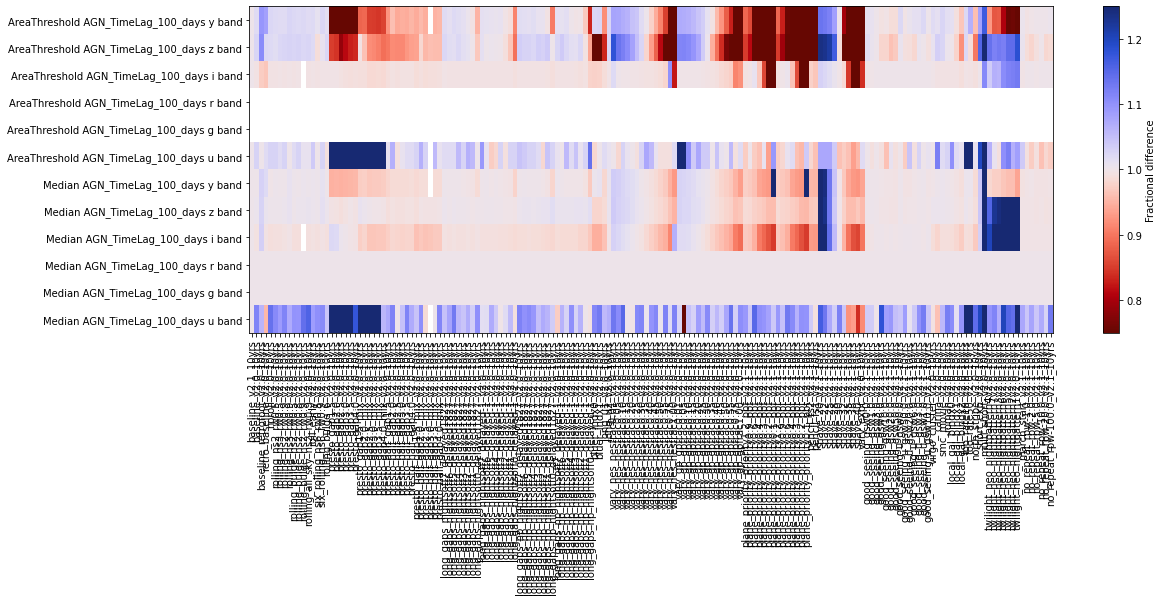

In [12]:
# Plot the *normalized* values
k = 'AGN timelag'
fig, ax = maf.plot_run_metric_mesh(summaries.loc[runs, mset.loc[k]['metric']], 
                                   baseline_run='baseline_v2.1_10yrs',
                                  color_range=0.5,
                                   metric_label_map=mset.loc[k]['short_name'],
                                  metric_set=mset.loc[k])
fig.set_figwidth(18)

(0.5, 1.5)

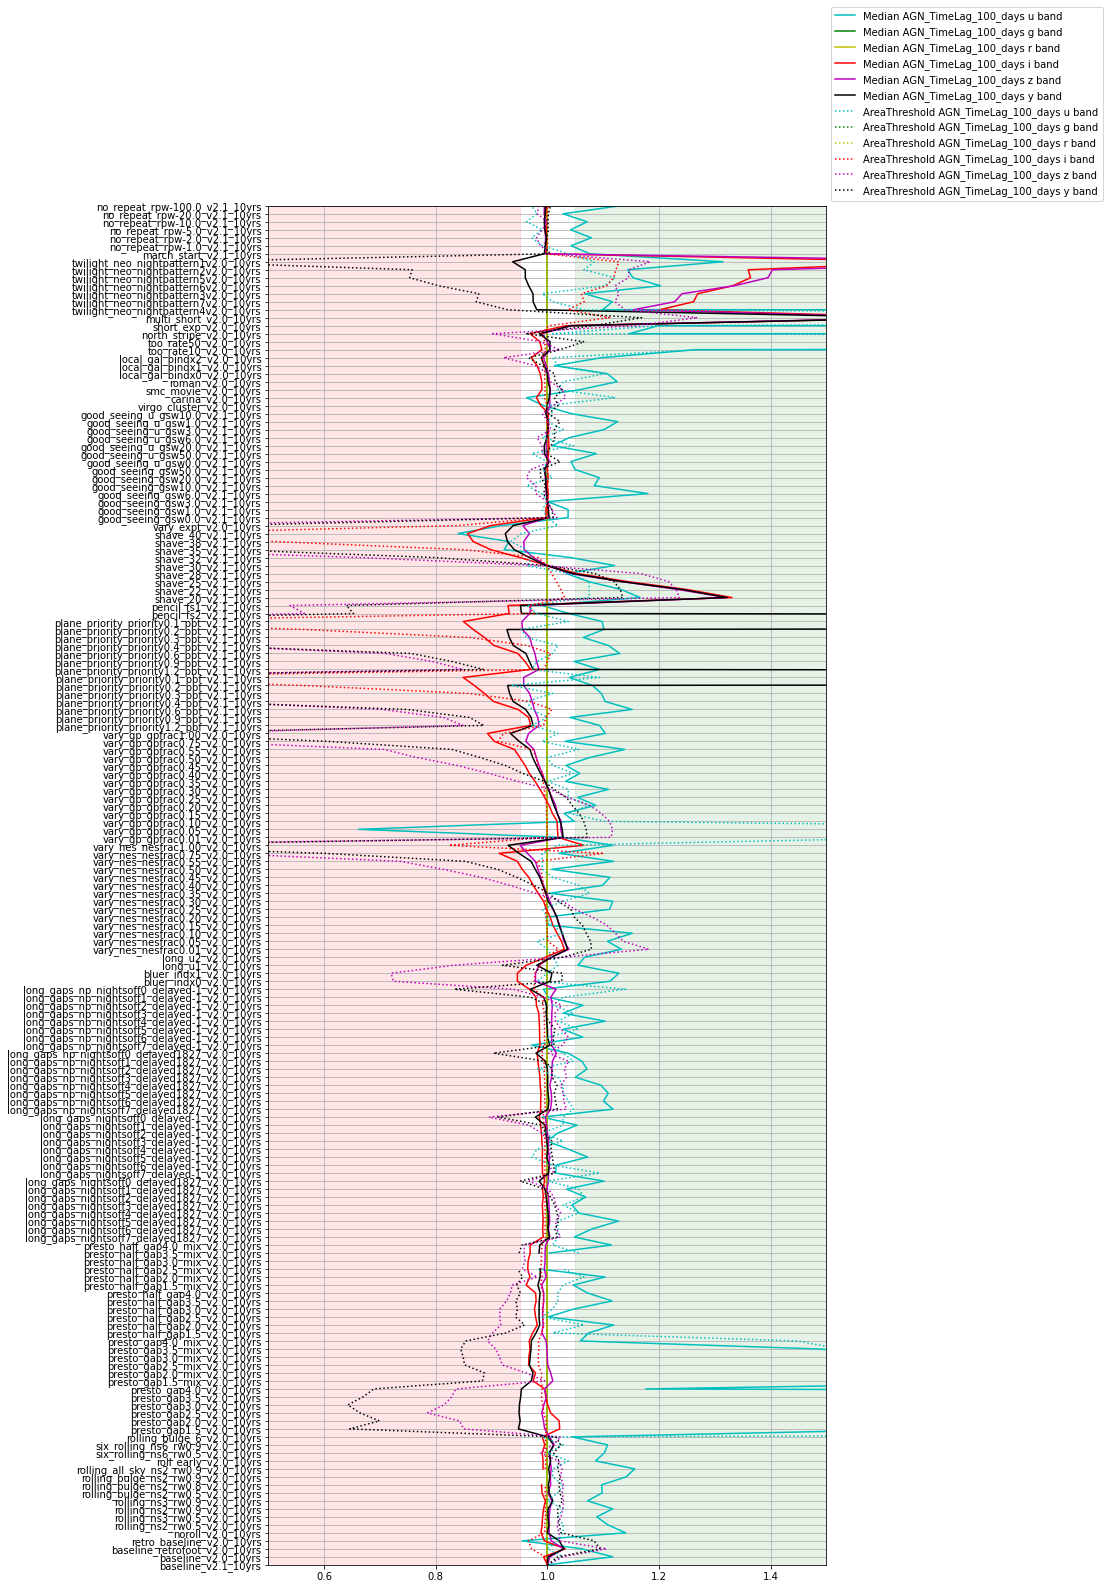

In [13]:
# Plot the normalized values, in a different way
fig, ax = maf.plot_run_metric(summaries.loc[runs, mset.loc[k]['metric']],
                             baseline_run='baseline_v2.1_10yrs',
                             metric_label_map=mset.loc[k]['short_name'],
                             metric_set=mset.loc[k],
                             horizontal_quantity='value',
                             vertical_quantity='run')
fig.set_figheight(25)
ax.set_xlim(0.5, 1.5)